# Dataset

Load the training data. 

In [9]:
import csv
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

csv_file = "trainingdata/driving_log.csv"

# Load the CSV file into samples[]
samples = []
with open(csv_file) as f:
    reader = csv.reader(f)
    for row in reader:
        samples.append(row)

# Split the data into training set and test set
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def get_file_name(full_path):
    return ("trainingdata/IMG/" + full_path.split('/')[-1])

def generator(samples, batch_size=32):
    num_samples = (int(len(samples)/batch_size))*batch_size
    correction = 0.2
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image = cv2.imread(get_file_name(batch_sample[0]))
                center_angle = float(batch_sample[3])
            
                left_image = cv2.imread(get_file_name(batch_sample[1]))
                left_angle = center_angle + correction
            
                right_image = cv2.imread(get_file_name(batch_sample[2]))
                right_angle = center_angle - correction
              
                images.extend([center_image, left_image, right_image])
                angles.extend([center_angle, left_angle, right_angle])
                

            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

Build a Model using Keras

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D

#Create the Sequential model
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation="relu"))
model.add(Dropout(0.1))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Dropout(0.1))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.1))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

Fit the model

In [11]:
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
history_object = model.fit_generator(train_generator, samples_per_epoch= (int(len(train_samples)/32))*32,
                                     validation_data=validation_generator,
                                     nb_val_samples=len(validation_samples), 
                                     nb_epoch=7)

model.save('model.h5')
print("Model saved")

Epoch 1/7
37344/37376 [============================>.] - ETA: 0s - loss: 0.1059

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


37440/37376 [==============================] - 80s - loss: 0.1058 - val_loss: 0.0945
Epoch 2/7
37440/37376 [==============================] - 80s - loss: 0.0909 - val_loss: 0.0847
Epoch 3/7
37440/37376 [==============================] - 79s - loss: 0.0898 - val_loss: 0.0843
Epoch 4/7
37440/37376 [==============================] - 79s - loss: 0.0883 - val_loss: 0.0872
Epoch 5/7
37440/37376 [==============================] - 79s - loss: 0.0848 - val_loss: 0.0825
Epoch 6/7
37440/37376 [==============================] - 80s - loss: 0.0840 - val_loss: 0.0790
Epoch 7/7
37440/37376 [==============================] - 80s - loss: 0.0848 - val_loss: 0.0846
Model saved


dict_keys(['loss', 'val_loss'])


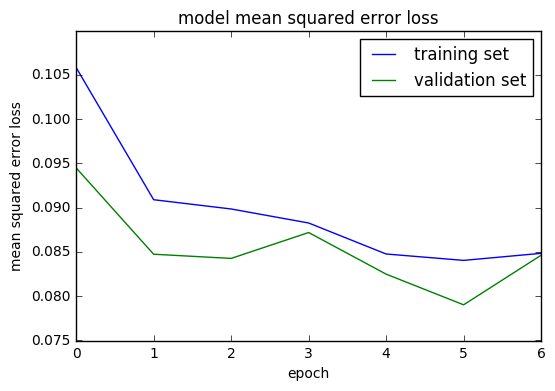

In [12]:
print(history_object.history.keys())
import matplotlib.pyplot as plt
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()